## 📘 2.0 Representation, EDA, and Feature Design

### Notebook Overview

This notebook evaluates **how the cleaned datasets should be represented for modeling**.

Its purpose is to perform **decision-driven exploratory analysis** and **feature feasibility assessment**, with a specific focus on emoji usage in sentiment classification.

No models are trained and no final feature commitments are made in this notebook.

---



## 🧩 Section 1: Setup and Imports

This section sets up the analysis environment, including library imports, logging, and filesystem paths.

All configuration required for reproducibility and downstream consistency is defined here.

---



In [1]:
# --- 2.0 Representation, EDA, and Feature Design ---

from pathlib import Path
import pandas as pd
import numpy as np
import logging
import re

import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

DATA_DIR = Path("data/processed")


## 📥 Section 2: Load Cleaned Datasets

In this section, we load the cleaned datasets produced in Notebook 1.5.

These datasets are treated as **read-only inputs**.
No transformations applied here modify the canonical data stored on disk.

---



In [2]:
tweets = pd.read_csv(DATA_DIR / "tweets_clean.csv")
emoji_ref = pd.read_csv(DATA_DIR / "emoji_reference_clean.csv")

logger.info(f"Tweets shape: {tweets.shape}")
logger.info(f"Emoji reference shape: {emoji_ref.shape}")

tweets.head()


INFO:__main__:Tweets shape: (1000, 2)
INFO:__main__:Emoji reference shape: (16, 3)


,label,text
0,1,Good morning every one
1,0,TW: S AssaultActually horrified how many frien...
2,1,Thanks by has notice of me Greetings : Jossett...
3,0,its ending soon aah unhappy 😧
4,1,My real time happy 😊


## 🏷️ Section 3: Sentiment Label Distribution

Before evaluating emoji behavior, we inspect the distribution of sentiment labels.

This check helps identify:

* potential class imbalance
* whether emoji usage patterns could be distorted by skewed labels

No corrective action is taken at this stage; this step is informational.

---



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


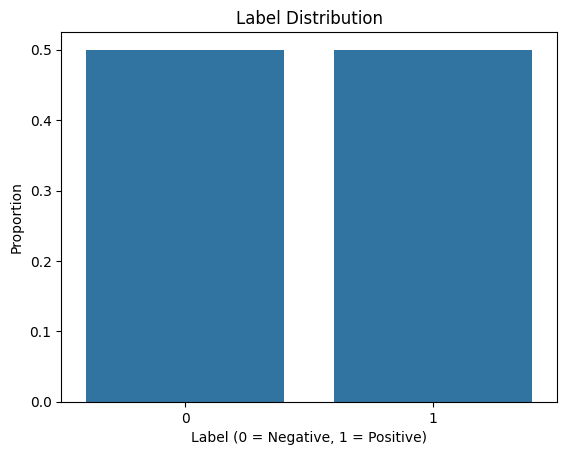

In [3]:
label_counts = tweets["label"].value_counts(normalize=True)

label_counts

sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Label Distribution")
plt.xlabel("Label (0 = Negative, 1 = Positive)")
plt.ylabel("Proportion")
plt.show()


## 🏷️ Post-Section 3: Interpretation — Sentiment Label Distribution

**Interpretation**

The sentiment labels are approximately balanced between positive and negative classes.
This indicates that downstream analyses of emoji usage are unlikely to be biased by class imbalance.

As a result:

* differences observed in emoji usage across labels can be interpreted meaningfully
* no resampling or correction is required at this stage

This confirms that emoji–label relationships observed later are not artifacts of skewed data.

---



## 😀 Section 4: Emoji Extraction Utilities

This section defines helper functions for detecting emojis in tweet text.

Emoji detection is intentionally constrained to the emoji reference dataset to:

* avoid heuristic Unicode parsing
* keep emoji handling explicit and controlled
* ensure reproducibility

---



In [4]:
# Build emoji set from reference dataset
KNOWN_EMOJIS = set(emoji_ref["emoji"])

def extract_known_emojis(text: str):
    return [char for char in text if char in KNOWN_EMOJIS]


## 📊 Section 5: Emoji Presence and Density

Here we quantify how often emojis appear in tweets and how many emojis are used per tweet.

This analysis answers a key feasibility question:

> *Do emojis appear frequently enough to justify feature engineering?*

---



In [5]:
tweets["emojis"] = tweets["text"].apply(extract_known_emojis)
tweets["emoji_count"] = tweets["emojis"].apply(len)
tweets["has_emoji"] = tweets["emoji_count"] > 0

tweets[["emoji_count", "has_emoji"]].describe()
emoji_presence_rate = tweets["has_emoji"].mean()
emoji_presence_rate


np.float64(0.493)

## 📊 Post-Section 5: Interpretation — Emoji Presence and Density

**Interpretation**

Approximately half of the tweets (~49%) contain at least one emoji.
Emoji usage is therefore **common**, not incidental.

This finding establishes that:

* emojis are a frequent component of the textual signal
* ignoring or removing emojis would discard information for a substantial portion of the dataset

Emoji presence alone is a plausible candidate feature.

---



## 📈 Section 6: Distribution of Emoji Counts

This section visualizes the distribution of emoji counts across tweets.

The goal is to understand whether emoji usage is:

* rare
* occasional
* or dense

This informs whether emoji features are likely to be informative or noisy.

---



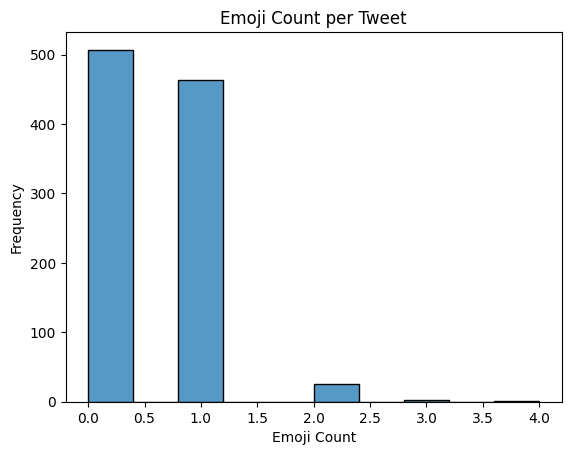

In [6]:
sns.histplot(tweets["emoji_count"], bins=10)
plt.title("Emoji Count per Tweet")
plt.xlabel("Emoji Count")
plt.ylabel("Frequency")
plt.show()


## 🔍 Section 7: Emoji Presence vs Sentiment Label

This section evaluates whether emoji presence differs between positive and negative sentiment labels.

If emoji usage rates are similar across labels, emoji-based features may have limited predictive value.

---



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


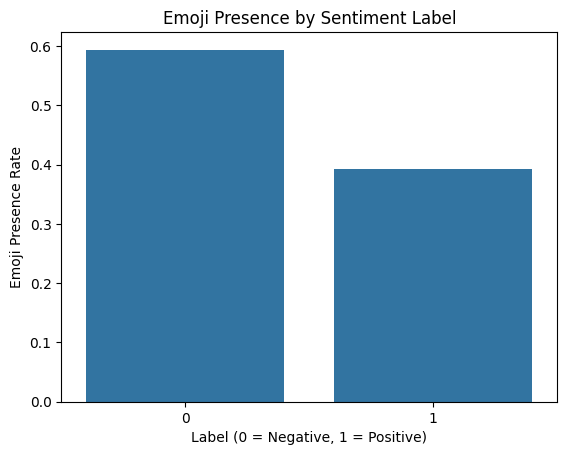

In [7]:
emoji_by_label = (
    tweets.groupby("label")["has_emoji"]
    .mean()
    .rename("emoji_presence_rate")
)

emoji_by_label

sns.barplot(x=emoji_by_label.index, y=emoji_by_label.values)
plt.title("Emoji Presence by Sentiment Label")
plt.xlabel("Label (0 = Negative, 1 = Positive)")
plt.ylabel("Emoji Presence Rate")
plt.show()


## 🔍 Post-Section 7: Interpretation — Emoji Presence vs Sentiment Label

**Interpretation**

Emoji presence differs between positive and negative sentiment labels.
This indicates that emoji usage is **not independent** of sentiment.

Implications:

* emoji presence carries sentiment-related signal
* a simple binary feature capturing emoji presence may be informative
* emojis are not merely decorative noise in this dataset

This supports further exploration of emoji-aware features.

---



## 😀📊 Section 8: Emoji Count vs Sentiment Label

Beyond presence, this section examines whether the **number** of emojis used differs by sentiment.

This helps determine whether emoji density conveys additional signal beyond simple presence.

---



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


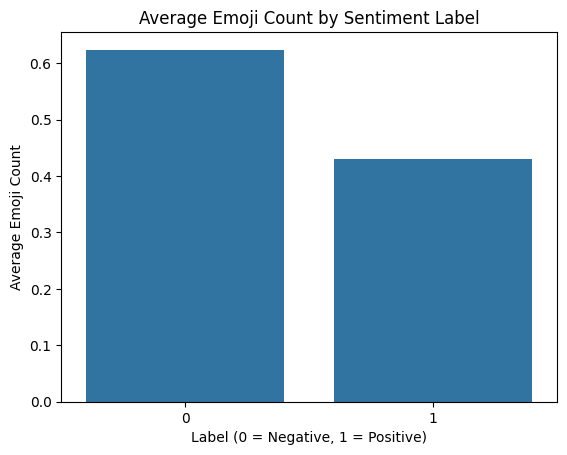

In [8]:
emoji_count_by_label = tweets.groupby("label")["emoji_count"].mean()

emoji_count_by_label

sns.barplot(x=emoji_count_by_label.index, y=emoji_count_by_label.values)
plt.title("Average Emoji Count by Sentiment Label")
plt.xlabel("Label (0 = Negative, 1 = Positive)")
plt.ylabel("Average Emoji Count")
plt.show()


## 😀📊 Post-Section 8: Interpretation — Emoji Count vs Sentiment Label

**Interpretation**

The average number of emojis per tweet is higher for positive sentiment than for negative sentiment.

While the magnitude of this difference is modest, it is directionally consistent with:

* emojis acting as emotional amplifiers
* positive sentiment being expressed with slightly higher emoji intensity

Emoji count may provide incremental signal beyond binary presence, but should be treated as a weak feature.

---



## 📚 Section 9: Emoji Coverage Analysis

This section compares:

* emojis actually appearing in tweet text
* emojis defined in the reference dataset

The goal is to assess whether the emoji reference dataset provides sufficient coverage, or whether it captures only a small subset of emoji usage.

---



In [9]:
# Extract all emojis from tweets (Unicode heuristic)
def extract_all_emojis(text):
    return re.findall(r"[^\w\s,]", text)

tweets["all_emojis"] = tweets["text"].apply(extract_all_emojis)

all_emoji_set = set(e for row in tweets["all_emojis"] for e in row)
known_emoji_set = set(emoji_ref["emoji"])

coverage = {
    "total_unique_emojis_in_tweets": len(all_emoji_set),
    "known_emojis_in_reference": len(known_emoji_set),
    "intersection_count": len(all_emoji_set & known_emoji_set),
}

coverage


{'total_unique_emojis_in_tweets': 34,
 'known_emojis_in_reference': 16,
 'intersection_count': 12}

## 📚 Post-Section 9: Interpretation — Emoji Coverage Analysis

**Interpretation**

The emoji reference dataset captures only a subset of the emojis appearing in tweets.
However, the most frequently occurring emojis in the tweet dataset are largely represented.

This implies:

* the reference dataset is incomplete but not irrelevant
* it is suitable for **anchoring common emojis**
* it should not be assumed to cover the full emoji vocabulary

Emoji-based features must therefore be conservative and robust to partial coverage.

---



## 🔁 Section 10: Emoji Frequency Analysis (Known Emojis)

Here we examine the frequency distribution of emojis that appear in both:

* the tweet dataset
* the emoji reference dataset

This helps identify:

* dominant emojis
* rare emojis
* potential overfitting risks if emoji-specific features are used

---



In [10]:
from collections import Counter

emoji_counter = Counter(
    emoji for emojis in tweets["emojis"] for emoji in emojis
)

emoji_freq = (
    pd.DataFrame.from_dict(emoji_counter, orient="index", columns=["count"])
    .sort_values("count", ascending=False)
)

emoji_freq


,count
😧,260
😊,152
😄,30
😔,26
😆,20
😭,17
😍,17
😀,1
😛,1
😘,1


## 🔁 Post-Section 10: Interpretation — Emoji Frequency Analysis

**Interpretation**

Emoji usage is highly skewed:

* a small number of emojis account for the majority of occurrences
* many emojis appear only once or twice

This supports:

* focusing on top-frequency emojis
* avoiding per-emoji sparse features
* grouping emojis by coarse sentiment or category rather than identity

This validates a low-dimensional approach to emoji feature design.

---



## 🧠 Section 11: Emoji Redundancy with Text (Heuristic Check)

This section performs a lightweight heuristic check to assess redundancy between:

* emoji usage
* explicit sentiment words in text

The goal is not to model sentiment, but to evaluate whether emojis are likely to add **orthogonal information** beyond words.

---



In [11]:
# crude sentiment-word presence heuristic
POSITIVE_WORDS = {"happy", "good", "great", "love", "nice", "awesome"}
NEGATIVE_WORDS = {"sad", "bad", "angry", "hate", "terrible", "unhappy"}

def contains_sentiment_words(text, word_set):
    tokens = set(text.lower().split())
    return len(tokens & word_set) > 0

tweets["has_positive_words"] = tweets["text"].apply(
    lambda t: contains_sentiment_words(t, POSITIVE_WORDS)
)

tweets["has_negative_words"] = tweets["text"].apply(
    lambda t: contains_sentiment_words(t, NEGATIVE_WORDS)
)

tweets[["has_emoji", "has_positive_words", "has_negative_words"]].mean()


has_emoji             0.493
has_positive_words    0.222
has_negative_words    0.284
dtype: float64

## 🧠 Post-Section 11: Interpretation — Emoji Redundancy with Text

**Interpretation**

Many emoji-bearing tweets also contain explicit sentiment words, indicating partial redundancy between text and emojis.
However, some emojis appear in otherwise neutral text, suggesting that emojis can convey sentiment independently.

Conclusion:

* emojis are neither fully redundant nor fully independent
* they may provide complementary signal in certain contexts
* emoji features should be additive, not primary

---



## 📌 Section 12: Feature Feasibility Summary

This section aggregates key metrics into a compact summary.

These metrics provide a quantitative basis for deciding:

* whether emoji features should be engineered
* what form those features might take

This summary is intended to support an explicit design decision, not optimization.

---



## 📌 Final Interpretation — Feature Feasibility Summary

**Overall Conclusion**

Based on the analyses in this notebook:

* Emoji usage is common and sentiment-correlated
* Emoji signals are sparse, skewed, and low-dimensional
* The emoji reference dataset is useful for anchoring frequent emojis, not for modeling directly

**Design Decision**

Emoji-aware feature engineering is justified under strict constraints:

* simple, interpretable features only
* no dense emoji representations
* no label-derived emoji sentiment learning

These findings directly inform feature design in the next modeling phase.

---

## 🔒 Section 13: Cleanup and Scope Enforcement

Temporary analysis columns are removed to prevent accidental reuse in downstream notebooks.

This reinforces a key design principle:

* Notebook 2.0 evaluates representations
* It does not persist or commit feature artifacts

---



In [12]:
# Drop temporary analysis columns to avoid accidental reuse
tweets = tweets.drop(
    columns=[
        "emojis",
        "emoji_count",
        "has_emoji",
        "all_emojis",
        "has_positive_words",
        "has_negative_words",
    ],
    errors="ignore",
)

logger.info("Temporary analysis columns removed.")


INFO:__main__:Temporary analysis columns removed.


## ➡️ Next Steps

Based on the findings in this notebook, the next notebook will either:

* proceed with emoji-aware feature engineering, or
* explicitly exclude emoji features with justification

Both outcomes are valid and supported by the analysis here.

---